# Forest Fire Burn Area Prediction

Written by: Marshall Mykietyshyn

Data hosted on [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires).

The purpose of this notebook is to predict the forest fire burn area. This is a popular regression dataset found on both Kaggle and the UCI Machine Learning Repository. The two data sets are identical, but the one used here was downloaded from UCI. The forest fire weather index (FWI) system features FFMC, DMC, DC and ISI are described [here](https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi). The target variable is burn area, which can be predicted by a set of feature variables listed below. The data to be used is already preprocessed by checking for missing values, outliers and converting the categorical features numerical values. However, there are unbalanced features that must be addressed, the target has nearly a 50% proportion of zeros, and the features are generally not Gaussian distributed. 

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: 0 to 11
4. day - day of the week: 0 to 6
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3
7. DC - DC index from the FWI system: 7.9 to 860.6
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40
12. rain - outside rain in mm/m2 : 0.0 to 6.4
13. area - the burned area of the forest (in ha): 0.00 to 1090.84

## Outline of Methods

### 1. Predicting burn area directly

The first model attempts to predict the burn area directly using a regression analysis. The "day" category is dropped, as it does not seem likely that this has a significant impact on the conditions that would cause a fire to occur. Additionally, "rain" is such an imbalanced feature that it cannot be properly balanced by either resampling or a transformation (eg. logistic), and is therefore dropped to avoid biasing the model. 

Following this, the distribution of data points by month show that there is much more data for the months of August and September than for other months. Since it makes sense that fires likely occur in these months, this seems like it could bias the data. Therefore, three different methods for balancing the dataset are implemented.

- **Method 1**: Upsampling from months that occur less frequently in the data (minority classes). The likelihood of sampling a particular month is inversely weighted by the frequency of that month in the original data. These weights are updated after each sample. This method quickly balances the infrequent categories, but requires many resamples to fully balance the data. Therefore, the data is only balanced to a certain degree. One drawback of this method is that some months contain only a single data point. That means all upsampled data for these months are represented by a single measurement, which can lead to overfitting the training data. 
- **Method 2**: Splitting the high frequency months (majority classes) into subsets, then combining each subset with the full set of minority class data. This has a similar effect as upsampling. Although it does not balance all the classes, it does avoid extreme overfitting that may result from upsampling. Since the majority data is split into multiple subsets for both the training and test data, this is an ensemble method, where the model performance is given as an average across the subsets. This idea was taken from this [Kaggle answer](https://www.kaggle.com/questions-and-answers/201922).
- **Method 3**: Combining the two previously described methods, where the data is first upsampled to a lesser degree, then split into larger subsets than in the second method. This attempts to balance the benefits of the two methods. 

Multiple models are fitted to the data, and their results compared. In all cases, following balancing and splitting into training and test sets, the data is whitened. This is because whitening affects some of these model classes, and we wish to compare performance across models. In order to find the best set of hyperparameters for each model class, a grid search using sklearn's built-in GridSearchCV feature is used. This utilizes k-fold cross-validation and random shuffling of the data before splitting the folds, to minimize model bias. Finally, the best model's performance is measured on a test set of the data, and the results are compared across models.

Note: In doing research for how to format categorical data for regression analysis, it was learned that the data must be encoded, to avoid implying some kind of hierarchical order on data that has no inherent importance associated with the order of the categories (i.e. nominal categories). This is most simply done using one-hot encoding. However, when features consist of a large number of categories, this can lead to an explosion in the number of training features and the "curse of dimensionality" which results in the exponential increase of training times. To avoid this, encoding schemes can be used to reduce the number of features. Of these schemes, the one that made the most sense to me is hash encoding, where a hash function is used to encode the categories. Unfortunately, some hash functions allow the possibility of collisions, which is undesirable. On the other hand, binary encoding offers a strong reduction in the number of features required, and avoids collisions. Since sklearn does not offer a built-in implementation for binary encoding, I wrote a function to perform this task. 

### 2. Two part analysis: Classification and Regression

This model splits the problem into two parts, in an attempt to address the imbalanced distribution of the target variable. This is suggested in the paper "[Analyzing Skewed Continuous Outcomes With Many Zeros: A Tutorial for Social Work and Youth Prevention Science Researchers](https://doi.org/10.1086/701235)". Since there is an approximately even amount of data points where a fire occurs vs. where no fire occurs, this addresses the problem of having an imbalanced target variable. The data is split into two categories $fire = 1$ (fire occurs) and $fire = 0$ (no fire occurs). These categories constitute a new target variable for the classification problem. 

The data is balanced, split and whitened the same way as in the first analysis. Classification is then performed on this data. For each data point that is identified as having a target value of $fire = 1$, a regression analysis is subsequently performed to estimate the size of the fire. 

Note: Unfortunately, since the classifier was barely able to predict above chance levels, the regression model is not implemented. This is discussed further in the Conclusion section at the bottom of this notebook.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from my_regression import whitening_transform


In [2]:
def weighted_upsample(data, feature, n_samples=500, seed=123456, plot=True):
    """ Upsamples the data, weighted by the distribution of a given feature.
    
    This function attempts to balance the given dataset by upsampling based on
    an inverse relationship to the current distribution of a particular feature.
    Data points associated with frequently occuring insatances of a feature are
    less likely to be sampled, and vice versa. For example, if there are two
    categories, with one occuring 4 times and the other occurring once, the
    minority feature will be four times as likel to be sampled. The weights
    are recalculated after each sample is added to the dataset.
    
    This function currently only works with discretized or categorical features.
    There is no stopping condition, and the number of samples must be chosen.
    Therefore, if an insufficient number is chosen, the data set will not become
    balanced.
    
    Parameters
        data: DataFrame = the dataset to be upsampled (and/or balanced)
        feature: str = the feature whose distribution determines the weighting
        n_samples: int = the number of samples to add to the dataset
        seed: int = the random seed used to make the process repeatable
        plot: bool = True -> plots a histogram of the feature distribution
        
    Returns
        resampled_data: DataFrame = the upsampled/balanced dataset
    """
    
    counts = len(data[feature].value_counts())
    month_wts = np.zeros(counts)
    upsampled_data = data.copy()
    np.random.seed(seed)
    for i in range(n_samples):
        # Weight the sampling by the current distribution
        counts = upsampled_data[feature].value_counts()
        ind_sort = list(counts.index.values.astype(int))
        month_wts[ind_sort] = (1 / counts.values) / (1 / counts.values).sum()

        # Select a month to sample from and resample from that selection
        month_id = np.random.choice(12, p=month_wts)
        month_data = upsampled_data.loc[upsampled_data[feature] == month_id]
        new_sample = resample(month_data, n_samples=1)

        # Append the new sample to the existing data
        upsampled_data = pd.concat([upsampled_data, new_sample], ignore_index=True)

    if plot:
        sns.countplot(x=upsampled_data[feature])
        
    return upsampled_data


def resample_ensemble(major_class, minor_class, n_folds=5, shuffle=True, seed=123456):
    """ Splits unbalanced data into subsets (folds).
    
    In each fold, the minority class is fully represented, while the majority
    class (the one with high frequency feature occurrences) is split into folds.
    This is an ensemble because the model can then be trained on each individual
    subset, and the final answer can be the average of the individually trained
    models.
    
    Parameters
        major_class: nd.array (observations, features) = the data corresponding
            to the high frequency class(es)
        minor_class: nd.array (observations, features) = the data corresponding
            to the low frequency class(es)
        n_folds:int = the number of subsets to split the majority class into
        shuffle: bool = indicates whether the data should be shuffled
        seed: int = the random seed used to make the process repeatable
        
    Returns
        folds: list(tuples) = the X and y data for each resampled subset
    """
    
    # Shuffle the data to avoid bias
    if shuffle:
        major_class.sample(frac=1, random_state=seed)
    fold_sz = len(major_class) // n_folds
    folds = []
    for k in range(n_folds):
        major_fold = major_class.iloc[k * fold_sz:(k + 1) * fold_sz, :]
        comb_data = pd.concat([minor_class, major_fold], axis=0)
        this_fold = comb_data.iloc[:, :-1], comb_data.iloc[:, -1]
        folds.append(this_fold)
    
    return folds


def BinaryEncoder(data, col_ls):
    """ Encodes numericized categorical data as a set of binary columns.
    
    Categorical data needs to be encoded such that it is usable by ML algorithms.
    However, large numbers of categories in one-hot encoding leads to large
    feature dimensions. Therefore, this function uses binary encoding to reduce
    the space required to encode these features. Binary encoding avoids the issue
    of collisions, which occurs with other methods such as hash encoding.
    
    The length of the binary encoding required is calculated based on the number
    of unique categories for each column. The encoded columns are concatenated
    at the beginning of the data frame.
    
    This function requires that the categorical data has already been converted
    to be represented by a range of ints. This will be updated in later versions
    of the function.
    
    Paramters
        data: DataFrame = all data
        col_ls: list = list of categorical column names to be encoded
        
    Returns
        enc_data: DataFrame = categorical data encoded columns
        n_enc_col: int = total number of encoded columns in output
    """
    
    n_enc_col = 0
    for i, col in enumerate(col_ls):
        # Find the number of unique categories
        n_cats = len(data[col].unique())
        
        # Determine the length of the binary encoding
        n_dig = len(format(data[col].max(), 'b'))
        n_enc_col += n_dig
        
        # Calculate the encoding for each category
        bin_enc = np.zeros((len(data), n_dig), dtype=int)
        for n in range(n_cats):
            inds = data.loc[data[col] == n].index
            bin_val = [int(x) for x in format(n, f'0{n_dig}b')]
            bin_enc[inds, :] = bin_val
            
        # Assign new column names
        col_names = []
        for d in range(n_dig):
            col_names.append(f'month{d}')
        
        # Concatenate the encoded columns
        if i == 0:
            enc_data = pd.DataFrame(bin_enc, columns=col_names)
        else:
            enc_data = pd.concat([pd.DataFrame(bin_enc, columns=col_names), enc_data], axis=1)
        
    return enc_data, n_enc_col


def train_test_pd_split(data, test_size=0.2, seed=123456):
    """ Splits the data and then recombines it into a pandas data frame.
    
    This function uses sklearn's train_test_split function to split the data, but
    the subsequently recombines it into data frames for further processing (eg.
    resampling or upsampling). The function assumes there is only a single target
    variable. 
    
    Parameters
        data: DataFrame = all data
        test_size: float = fraction of data to compose test set
        seed: int = the random seed used to make the process repeatable
        
    Returns
        train_set: Data Frame = training dataset
        test_set: Data Frame = test dataset
    """
    
    # Split into training and test sets
    data_nd = data.values
    X_nd, y_nd = data_nd[:, :-1], data_nd[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_nd, y_nd, test_size=test_size, random_state=seed)

    # Recombine into data frames for further processing
    train_set = pd.DataFrame(np.hstack((X_train, y_train[:, None])))
    train_set.columns = data.columns
    test_set = pd.DataFrame(np.hstack((X_test, y_test[:, None])))
    test_set.columns = data.columns
    
    return train_set, test_set


In [3]:
# Load the preprocessed data
data = pd.read_csv('data/forestfires_preprocessed.csv')

# Eliminate the day and rain categories
data.drop(columns=['day', 'rain'], inplace=True)


In [4]:
# Encode the categorical 'month' feature using binary encoding
cat_cols = ['month']
enc_data, n_enc_col = BinaryEncoder(data, cat_cols)
data = pd.concat([enc_data, data], axis=1)


In [5]:
# Split into training and test sets
data_train, data_test = train_test_pd_split(data, seed=66)


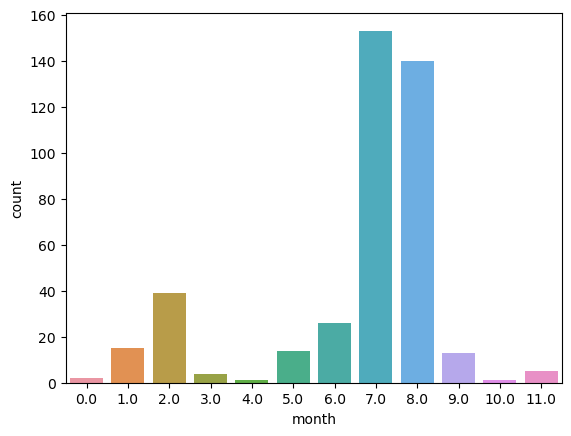

In [6]:
# Look at the distribution of months in the training data
sns.countplot(x=data_train.month);


Index(['month0', 'month1', 'month2', 'month3', 'X', 'Y', 'month', 'FFMC',
       'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'],
      dtype='object')

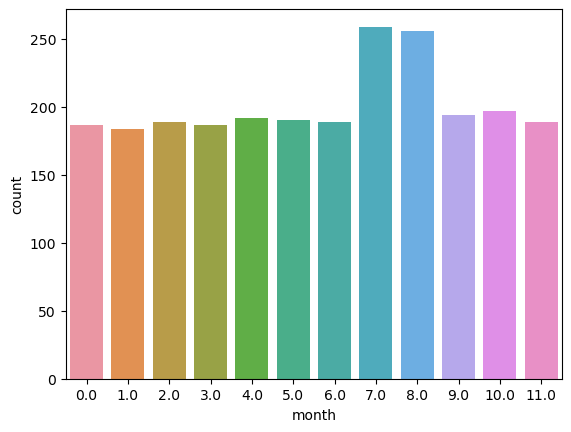

In [7]:
# Balance the dataset by resampling, weighted by frequency
resamp_train1 = weighted_upsample(data_train, 'month', n_samples=2000, plot=True)
X_train_re1, y_train_re1 = resamp_train1.iloc[:, :-1], resamp_train1.iloc[:, -1]
display(X_train_re1.columns)

# Balance the dataset by splitting the high frequency data into a training ensemble
major2 = data_train.loc[(data_train.month == 7) | (data_train.month == 8)]
minor2 = data_train.loc[(data_train.month != 7) & (data_train.month != 8)]
resamp_train2 = resample_ensemble(major2, minor2, n_folds=5)

# Balance the dataset by first upsampling, and then splitting into a resampled ensemble
resamp_train3 = weighted_upsample(data_train, 'month', n_samples=300, plot=False)
major3 = resamp_train3.loc[(resamp_train3.month == 7) | (resamp_train3.month == 8)]
minor3 = resamp_train3.loc[(resamp_train3.month != 7) & (resamp_train3.month != 8)]
resamp_train3 = resample_ensemble(major3, minor3, n_folds=3)

all_resamp_data = [(X_train_re1, y_train_re1), resamp_train2, resamp_train3]


In [8]:
# Whiten the resampled training data
all_resamp_white_train  = []
for i, re_data in enumerate(all_resamp_data):
    if isinstance(re_data, list):
        ens_resamp_white_train = []
        for j, (Xt, yt) in enumerate(re_data):
            # Select only the numerical data
            new_Xt = Xt.drop(columns=cat_cols)
            num_Xt = new_Xt.iloc[:, n_enc_col:]

            # Centering
            num_Xt_center = num_Xt - num_Xt.mean(axis=0)

            # Whitening
            W = whitening_transform(num_Xt_center)
            num_X_white_train = (W @ num_Xt_center.T).T

            # Recombine with categorical data
            X_white_train = pd.concat([new_Xt.iloc[:, :n_enc_col], num_X_white_train], axis=1)
            X_white_train.columns = new_Xt.columns
            # display(X_white_train)
            
            # Append to ensemble list
            ens_resamp_white_train.append((X_white_train, yt))
            
        # Append to resample list
        all_resamp_white_train.append(ens_resamp_white_train)
    else:
        # Select only the numerical data
        Xt, yt = re_data
        new_Xt = Xt.drop(columns=cat_cols)
        num_Xt = new_Xt.iloc[:, n_enc_col:]
        
        # Centering
        num_Xt_center = num_Xt - num_Xt.mean(axis=0)

        # Whitening
        W = whitening_transform(num_Xt_center)
        num_X_white_train = (W @ num_Xt_center.T).T

        # Recombine with categorical data
        X_white_train = pd.concat([new_Xt.iloc[:, :n_enc_col], num_X_white_train], axis=1)
        X_white_train.columns = new_Xt.columns
        # display(X_white_train)

        # Append to resample list
        all_resamp_white_train.append([(X_white_train, yt)])
    

In [9]:
# Whiten the test data using the numerical training features
# Extract the numerical data
new_X_train = data_train.drop(columns=cat_cols)
num_X_train = new_X_train.iloc[:, n_enc_col:-1]
new_X_test = data_test.drop(columns=cat_cols)
num_X_test = new_X_test.iloc[:, n_enc_col:-1]

# Center the data
num_X_train_center = num_X_train - num_X_train.mean(axis=0)
num_X_test_center = num_X_test - num_X_train.mean(axis=0)

# Whiten the data
W = whitening_transform(num_X_train_center)
num_X_white_test = (W @ num_X_test_center.T).T

# Recombine with the categorical data
X_white_test = pd.concat([data_test.iloc[:, :n_enc_col], num_X_white_test], axis=1)
X_white_test.columns = new_X_test.columns[:-1]
# display(X_white_test)


,0,1,2,3,4,5,6,7,8
count,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02
mean,9.381493e-16,6.126867e-16,-2.917540e-15,1.090886e-14,-5.399030e-16,-2.917431e-15,-1.490436e-15,3.238983e-15,-7.423938e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.172738e+00,-3.540376e+00,-1.363557e+00,-2.512980e+00,-6.364132e+00,-1.978750e+00,-2.571429e+00,-4.101450e+00,-2.270800e+00
25%,-9.210669e-01,-4.793545e-01,-6.377458e-01,-6.127328e-01,-6.082513e-01,-7.332775e-01,-7.513630e-01,-4.017955e-01,-8.063848e-01
50%,-2.418753e-01,-1.081428e-01,-2.890061e-01,6.804974e-02,-1.249496e-01,-2.621399e-01,-6.493251e-02,-6.032967e-02,-1.139663e-01
75%,1.105263e+00,5.256389e-01,3.254222e-01,6.549413e-01,6.988198e-01,3.971307e-01,5.501943e-01,4.942014e-01,6.021441e-01
max,2.110177e+00,2.009890e+00,3.375471e+00,3.460733e+00,3.678015e+00,9.648423e+00,2.608754e+00,6.937341e+00,3.634792e+00


<AxesSubplot:>

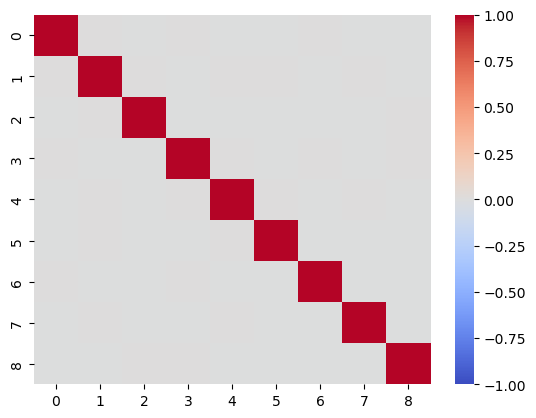

In [10]:
# Check whitening
# Means should be zero, variance should be one
display(num_X_white_train.describe())
# Covariance matrix should be the identity
sns.heatmap(np.cov(num_X_white_train.T), cmap='coolwarm', vmin=-1, vmax=1)

# # Visualize the data
# sns.pairplot(pd.DataFrame(num_X_white_train))


In [11]:
# Define a grid search to train and test the model
cv_split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=66)

# Random forest regressor
d_forest_reg = {'name': 'Random Forest',
                'model': RandomForestRegressor(random_state=66, warm_start=True),
                'params': {'n_estimators': [100, 200, 400, 800],
                           'max_depth': [1, 2, 4],
                           'min_samples_leaf': [1, 5, 10],
                           'ccp_alpha': [0., 0.0005]}}
d_forest_reg['grid'] = GridSearchCV(d_forest_reg['model'], d_forest_reg['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# SVR
d_svr = {'name': 'SVR',
         'model': SVR(),
         'params': {'kernel': ['rbf'],
                    'gamma': [1, 10, 100],
                    'C': [10, 100, 500],
                    'epsilon': [0.1, 0.5, 1]}}
d_svr['grid'] = GridSearchCV(d_svr['model'], d_svr['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# XGBoost
d_xgb = {'name': 'XGBoost',
         'model': XGBRegressor(gamma=10, reg_lambda=100),
         'params': {'n_estimators': [100, 200, 400, 800],
                    'eta': [0.1, 0.3],
                    'max_depth': [1, 5, 10],
                    'alpha': [0, 1, 10]}}
d_xgb['grid'] = GridSearchCV(d_xgb['model'], d_xgb['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# Assign the models to a list
reg_models = [d_forest_reg, d_svr, d_xgb]


In [12]:
# Find the best models using a hyperparameter grid search
for reg_model in reg_models:
    grid_search = reg_model['grid']
    resamp_params = []
    resamp_models = []
    resamp_score_avg = np.zeros(len(all_resamp_white_train))
    resamp_score_std = np.zeros_like(resamp_score_avg)
    for i, tmp_data in enumerate(all_resamp_white_train):
        if isinstance(tmp_data, list):
            ens_params = []
            ens_models = []
            ens_scores = np.zeros(len(tmp_data))
            for j, (Xt, yt) in enumerate(tmp_data):
                grid_search.fit(Xt, yt)
                ens_params.append(grid_search.best_params_)
                ens_models.append(grid_search.best_estimator_)
                ens_scores[j] = grid_search.best_score_
            resamp_params.append(ens_params)
            resamp_models.append(ens_models)
            resamp_score_avg[i] = ens_scores.mean()
            resamp_score_std[i] = ens_scores.std()
        else:
            Xt, yt = tmp_data
            grid_search.fit(Xt, yt)
            resamp_params.append(grid_search.best_params_)
            resamp_models.append(grid_search.best_estimator_)
            resamp_score_avg[i] = grid_search.best_score_
        
    reg_model['best_params'] = resamp_params
    reg_model['best_model'] = resamp_models
    reg_model['train_scores'] = (resamp_score_avg, resamp_score_std)
        

done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search
done search


In [13]:
# Score the best models on the test set
y_test = data_test.area.values
for reg_model in reg_models:
    best_models = reg_model['best_model']
    resamp_score_avg = np.zeros(len(all_resamp_white_train))
    resamp_score_std = np.zeros_like(resamp_score_avg)
    for j, models in enumerate(best_models):
        if isinstance(models, list):
            scores = np.zeros(len(models))
            for i, model in enumerate(models):
                y_pred = model.predict(X_white_test)
                scores[i] = r2_score(y_test, y_pred)
            resamp_score_avg[j] = scores.mean()
            resamp_score_std[j] = scores.std()
        else:
            y_pred = models.predict(X_white_test)
            resamp_score_avg[j] = r2_score(y_test, y_pred)
    reg_model['test_scores'] = (resamp_score_avg, resamp_score_std)


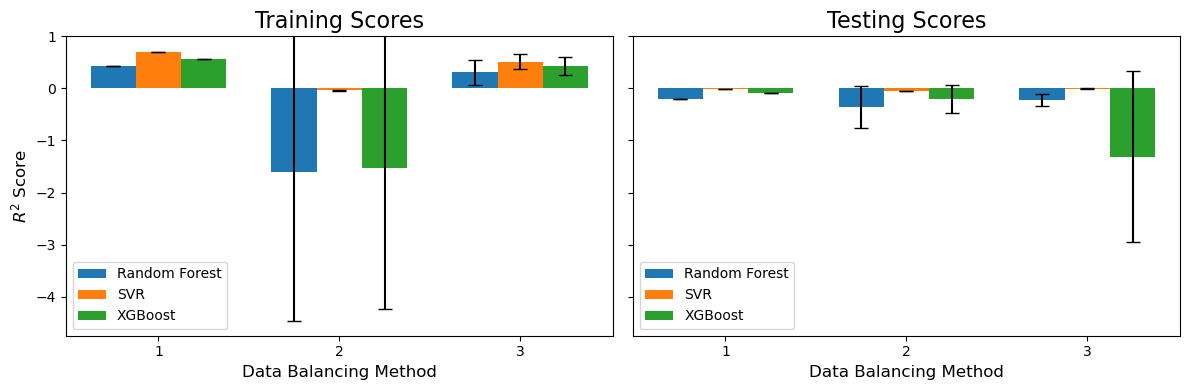

In [14]:
# Initialize the plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
N = len(reg_models)
r = np.arange(N)
width = 1 / (N + 1)

for i, reg_model in enumerate(reg_models):
    # Plot data
    name = reg_model['name']
    x_pos = r + i * width

    # Plot the training R2 scores
    train_avg = reg_model['train_scores'][0]
    train_std = reg_model['train_scores'][1]
    axes[0].bar(x_pos, train_avg, width=width, label=name)
    axes[0].errorbar(x_pos, train_avg, train_std, color='k', capsize=5, ls='none')
    
    # Plot the testing R2 scores
    test_avg = reg_model['test_scores'][0]
    test_std = reg_model['test_scores'][1]
    axes[1].bar(x_pos, test_avg, width=width, label=name)
    axes[1].errorbar(x_pos, test_avg, test_std, color='k', capsize=5, ls='none')

# Format the plot
axes[0].set_ylabel(r'$R^2$' + ' Score', fontsize=12)
axes[0].set_title('Training Scores', fontsize=16)
axes[1].set_title('Testing Scores', fontsize=16)
axes[0].set_ylim(top=1.)
for i in range(len(axes)):
    axes[i].set_xlabel('Data Balancing Method', fontsize=12)
    axes[i].set_xticks(r + 0.25, [1, 2, 3])
    axes[i].legend()
fig.tight_layout()


## Conclusions and Lessons Learned

The error bars in the above plot represent the standard deviation of ensemble data balancing methods (2 and 3), where the score is averaged across multiple subsets of the data. Since upsampling is not an ensemble method, the standard deviation of method \#1 is always zero. As mentioned in the outline, upsampling creates over fitting in training data (balancing methods 1 and 3), but does not improve test performance. As can be seen, there is a large discrepancy between the training and test performance, due to this overfitting. SVR appears to be the most consistent model across different data samples, making it appear to be the most robust model in this problem.

Although the upsampling method appears to outperform the ensemble methods, it should be noted that this dataset is relatively limited. Therefore, the folds of the ensemble methods may simply not contain enough information to properly train the model, resulting in poorer performance. This could be tested on a larger dataset in the future. 

Several of the models perform approximately equal to or worse than $R^2 = 0$ on the test data. Unfortunately, $R^2 = 0$ indicates that predicting the mean burn area will give an equally good answer (i.e. the trivial fit), so these models are essentially not predictive at all. Negative $R^2$ values indicate the model is worse than this constant prediction. For more information on $R^2$, see this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8279135/) and its references.


# Two-part Model: Classification & Regression

The idea behind this model is to split the dataset into two parts.
1. A classification task, to determine whether a fire occurs ("area" category must be converted to binary value)
2. A regression task using a subset of the data, to predict the burn area on the condition that a fire occurs
The separation of these two tasks should help address the imbalanced class problem that exists within the data. Addtionally, if the output of the classification model provides a likelihood, then this can be multiplied by the output of the regressor to generate a join likelihood for the burn area.


In [15]:
tmp_data = data.drop(columns=['month'])

# Isolate the rows where fires occur for later regression
reg_data = tmp_data.drop(data[data.area < 1e-3].index).reset_index(drop=True)
display(reg_data.tail(n=5))

# Convert the target to a binary category
cat_data = tmp_data.copy()
cat_data.loc[cat_data.area < 1e-3, 'area'] = 0
cat_data.loc[cat_data.area > 1e-3, 'area'] = 1
cat_data.rename(columns={'area': 'fire'}, inplace=True)
display(cat_data.tail(n=5))


,month0,month1,month2,month3,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area
265,0,1,1,1,5,4,91.0,166.9,752.6,7.1,21.1,71,7.6,2.17
266,0,1,1,1,6,5,91.0,166.9,752.6,7.1,18.2,62,5.4,0.43
267,0,1,1,1,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,6.44
268,0,1,1,1,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,54.29
269,0,1,1,1,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,11.16


,month0,month1,month2,month3,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,fire
512,0,1,1,1,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,1.0
513,0,1,1,1,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,1.0
514,0,1,1,1,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,1.0
515,0,1,1,1,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0
516,1,0,1,0,6,3,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0


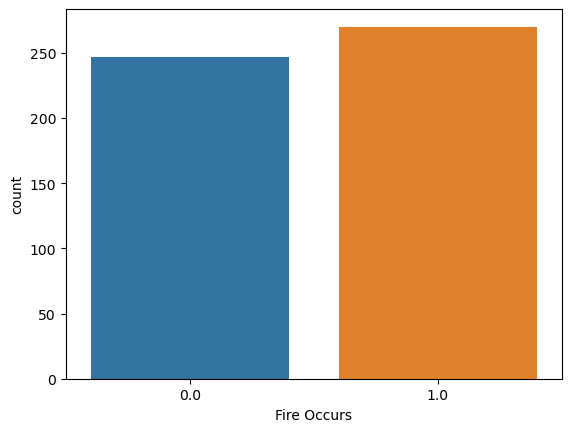

In [16]:
# Distribution of fire occurrence
ax = sns.countplot(x=cat_data.fire)
ax.set(xlabel='Fire Occurs');


In [17]:
# Split into training and test sets
cat_train, cat_test = train_test_pd_split(cat_data, seed=66)
display(cat_train.head(n=5))


,month0,month1,month2,month3,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,fire
0,1.0,0.0,0.0,0.0,5.0,4.0,92.9,133.3,699.6,9.2,21.9,35.0,1.8,1.0
1,0.0,1.0,1.0,1.0,1.0,2.0,94.8,108.3,647.1,17.0,18.6,51.0,4.5,0.0
2,0.0,1.0,1.0,1.0,7.0,4.0,94.8,227.0,706.7,12.0,23.3,34.0,3.1,0.0
3,0.0,0.0,1.0,1.0,6.0,3.0,88.0,17.2,43.5,3.8,15.2,51.0,2.7,0.0
4,0.0,1.0,1.0,1.0,7.0,4.0,91.8,175.1,700.7,13.8,21.9,73.0,7.6,0.0


In [18]:
# Whiten the data using the numerical training features
# Extract the numerical data
cat_num_X_train, cat_y_train = cat_train.iloc[:, n_enc_col:-1], cat_train.iloc[:, -1]
cat_num_X_test, cat_y_test = cat_test.iloc[:, n_enc_col:-1], cat_test.iloc[:, -1]

# Center the data
cat_num_X_train_center = cat_num_X_train - cat_num_X_train.mean(axis=0)
cat_num_X_test_center = cat_num_X_test - cat_num_X_train.mean(axis=0)

# Whiten the data
W = whitening_transform(cat_num_X_train_center)
cat_num_X_white_train = (W @ cat_num_X_train_center.T).T
cat_num_X_white_test = (W @ cat_num_X_test_center.T).T

# Recombine with the categorical data
cat_X_white_train = pd.DataFrame(np.hstack((cat_train.values[:, :n_enc_col], cat_num_X_white_train)))
cat_X_white_train.columns = cat_data.columns[:-1]
cat_X_white_test = pd.DataFrame(np.hstack((cat_test.values[:, :n_enc_col], cat_num_X_white_test)))
cat_X_white_test.columns = cat_data.columns[:-1]
# display(X_white_test)


In [19]:
# Random forest classifier
d_forest_cat = {'name': 'Random Forest',
                'model': RandomForestClassifier(random_state=66),
                'params': {'n_estimators': [100, 200, 400, 800],
                           'max_depth': [1, 5, 10],
                           'max_leaf_nodes': [2, 4, 8]}}
d_forest_cat['grid'] = GridSearchCV(d_forest_cat['model'], d_forest_cat['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# SVC
d_svc = {'name': 'SVC',
         'model': SVC(random_state=66),
         'params': {'kernel': ['rbf'],
                    'gamma': [0.1, 0.5, 1],
                    'C': [1, 10, 100]}}
d_svc['grid'] = GridSearchCV(d_svc['model'], d_svc['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# XGBoost
d_xgb_cat = {'name': 'XGBoost',
             'model': XGBClassifier(gamma=10),
             'params': {'n_estimators': [100, 200, 400, 800],
                        'eta': [0.1, 0.3],
                        'max_depth': [1, 5, 10],
                        'alpha': [0, 1, 10],
                        'lambda': [1, 10, 100]}}
d_xgb_cat['grid'] = GridSearchCV(d_xgb_cat['model'], d_xgb_cat['params'], scoring='r2', n_jobs=-1, cv=cv_split)

# Assign the models to a list
cat_models = [d_forest_cat, d_svc, d_xgb_cat]


In [20]:
# Fit the models and check the performance
for cat_model in cat_models:
    # Find the best model
    grid_search = cat_model['grid']
    grid_search.fit(cat_X_white_train, cat_y_train)
    print('done search')
        
    # Save the results
    cat_model['best_params'] = grid_search.best_params_
    cat_model['best_model'] = grid_search.best_estimator_
    cat_model['train_scores'] = grid_search.best_score_
    
    # Check the model accuracy
    cat_model['best_model'].fit(cat_X_white_train, cat_y_train)
    cat_model['accuracy'] = cat_model['best_model'].score(cat_X_white_test, cat_y_test)
    cat_model['y_pred'] = cat_model['best_model'].predict(cat_X_white_test)
    m_name = cat_model['name']
    m_acc = cat_model['accuracy']
    print(f'The {m_name} model accuracy is: {m_acc:3.2f}')
    # print(f'The {cat_model['name']} model accuracy is: {cat_model['accuracy']:3.2f}')


done search
The Random Forest model accuracy is: 0.55
done search
The SVC model accuracy is: 0.57
done search
The XGBoost model accuracy is: 0.51


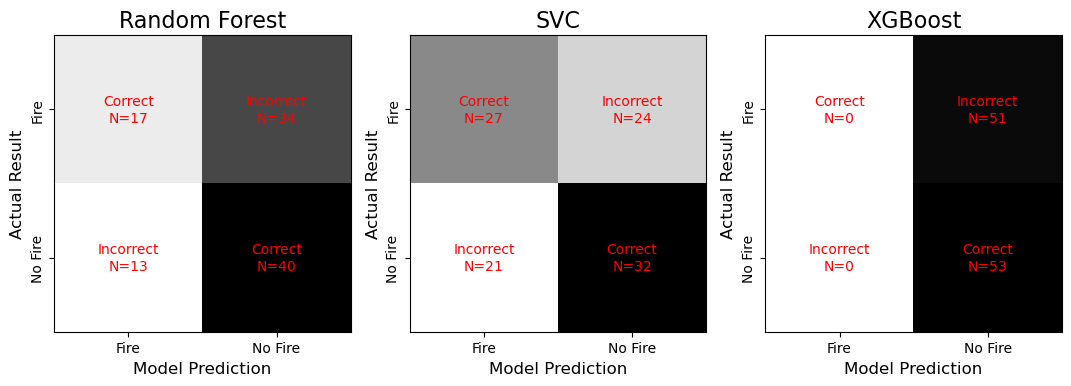

In [21]:
# Plot a confusion matrix
fig, axes = plt.subplots(1, len(cat_models), figsize=(13, 4))
for i, cat_model in enumerate(cat_models):
    conf_mat = confusion_matrix(cat_y_test, cat_model['y_pred'])
    axes[i].imshow(conf_mat, cmap='Greys')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Fire', 'No Fire'])
    axes[i].set_xlabel('Model Prediction', fontsize=12)
    axes[i].set_yticks([0, 1])
    axes[i].set_yticklabels(['Fire', 'No Fire'], va='center', rotation='vertical')
    axes[i].set_ylabel('Actual Result', fontsize=12)
    # axes[i].text(0, 0, f'Correct\nN={conf_mat[0, 0]}', c='white', ha='center', va='center')
    # axes[i].text(1, 0, f'Incorrect\nN={conf_mat[0, 1]}', c='k', ha='center', va='center')
    # axes[i].text(0, 1, f'Incorrect\nN={conf_mat[1, 0]}', c='k', ha='center', va='center')
    # axes[i].text(1, 1, f'Correct\nN={conf_mat[1, 1]}', c='white', ha='center', va='center')
    axes[i].text(0, 0, f'Correct\nN={conf_mat[0, 0]}', c='r', ha='center', va='center')
    axes[i].text(1, 0, f'Incorrect\nN={conf_mat[0, 1]}', c='r', ha='center', va='center')
    axes[i].text(0, 1, f'Incorrect\nN={conf_mat[1, 0]}', c='r', ha='center', va='center')
    axes[i].text(1, 1, f'Correct\nN={conf_mat[1, 1]}', c='r', ha='center', va='center')
    axes[i].set_title(cat_model['name'], fontsize=16);


## Conclusions and Lessons Learned

The classification models do not perform well. They are barely above chance level. Since this is a commonly analyzed dataset, I looked through some other analyses posted online, to determine whether my model is underperforming, or whether it is likely there is simply not enough information contained in the data to make an accurate assessment. The other analyses I found fit into one of several categories:
- Those whose models also did not perform better than chance ([here](https://manuelemacchia.com/forest-fires/#dataset) and [here](https://doi.org/10.3390/f13071129)), and hypothesized whether there may not enough information contained in the dataset to properly perform a machine learning analysis.
- Those which included a clear mistake, as with [this one](https://medium.com/mlearning-ai/the-experiment-of-forest-fires-prediction-using-deep-learning-d537e8c8e3a2#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6Ijc3Y2MwZWY0YzcxODFjZjRjMGRjZWY3YjYwYWUyOGNjOTAyMmM3NmIiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NjcyMTIxNTksImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwMzI2MTc0OTQyMTgzMzIzMTQ5NyIsImVtYWlsIjoibW15a2lldHlzaHluQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJuYW1lIjoiTWFyc2hhbGwgTXlraWV0eXNoeW4iLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUxtNXd1MlhCazBUVE1YWU1sNHlYeFgwbm8xVmU1RmEzclU5czg4NVpaX1U9czk2LWMiLCJnaXZlbl9uYW1lIjoiTWFyc2hhbGwiLCJmYW1pbHlfbmFtZSI6Ik15a2lldHlzaHluIiwiaWF0IjoxNjY3MjEyNDU5LCJleHAiOjE2NjcyMTYwNTksImp0aSI6IjNiNTMwZGQ0NjQzNTU2NmVmZWVjY2IzOTljZTY5M2YzYTlkNjI0MzIifQ.gVgYMLofs8XUiBRuq33bnZVI-PlQCorXfMbhyD6wJsaheHms8qoot8cdhzI2tDFBVGjhzTJ5AZMrF901_fGeQXOZERe90AHGI-pGQSHDd1H2Z9viCc3npFwDYAZ-bQMA7Rs9lYd0Dnawmlgi7IqXajMHbJMUUGy_nDiuZDwOeKVLrKZkmG7cbTkEfuI7YfPfaJyKqlMEEka7n56Wf-ztl2xGmgwtZcdKa17TNqwSlJ3kD6QGslDGJFxpyQChFRI5OUn6r5Leb8jl837bmxdAcUjGLC4EnbkiEURNvvvKGMu-76ocQJf17D2hvYSv9T9DVQI-ILLWqSX3QeaNVhS5VA), where they created a new target variable "size_category", but forgot to remove the "area" category (from which the new target is derived) from the input features. Thus, they are achieving nearly 100% accuracy in their classification, but the model is likely just training on the single feature from which the target is derived. This is just a linearly separable problem, and can be solved with 100% accuracy using the simplest ML model available.
- Those who only look at relative performance without asking what the absolute/baseline performance indicates, as with [here](https://www.sciencedirect.com/science/article/pii/S2589721721000118#s0040) and [here](https://fireecology.springeropen.com/articles/10.4996/fireecology.1101106). In this case, they never ask how good their best performing model is, using a metric that provides some kind of baseline, such as $R^2$. For example, in the [first linked article](https://www.sciencedirect.com/science/article/pii/S2589721721000118#s0040), the model is analyzed based on the relative RMSE values, with conclusions being drawn about the effectiveness of various measures such as data matching and feature selection. They go on to claim that their model "predict[s] total burn area... to a high degree of accuracy." This accuracy is associated with a lowest RMSE value of 61.88. The best SVR model trained in this notebook, with an $R^2 \approx 0$ has an RMSE of 25.38. Therefore, I think it's impossible to say that these models are performing with high accuracy, and indeed, to draw any conclusions about the effectiveness of analysis techniques from models that are performing so much worse than the trivial fit. 
- Those that apparently perform extremely well, such as [this paper](https://link.springer.com/content/pdf/10.1007/978-3-642-55032-4_31.pdf). Here, the authors use fuzzy C-means to categorize the data into one of three categories (no_burn_area, light_burn, and heavy_burn). With a single hidden layer neural network, they are then able to achieve a 97% classification accuracy. However, they do not provide enough details on their methodology to resproduce their results. For example, they do not specify how their training and test data are divided or whhat type of parameter tunging they perform. Given the difficulty of others to achieve even moderately accurate predictions in analyzing this dataset, and the number of mistakes I have found in published analyses, I am skeptical of these results. 

    The most apparent lesson here is that a lot of data science being posted online is not thorough enough, and fails to account for details that make the analysis redundant or inaccurate. This was also a conclusion I came to in going through the data science tutorials on another repo I forked. On the other hand, many of these analyses do a great job of visualizing the data and performing exploratory data analyses. [This paper in particular](https://doi.org/10.3390/su141610107) does a wonderful job of visualizing the spatial distribution of forest fires, including both their frequency and severity. These are skills that I would like to improve on, and will aim to do so in future projects.


In [22]:
# Show the RMSE for the SVR model
svr_dict = reg_models[1]
best_svr = svr_dict['best_model'][0][0]
y_svr = best_svr.predict(X_white_test)
svr_rmse = mean_squared_error(y_test, y_svr, squared=False)
svr_r2 = r2_score(y_test, y_svr)
print(f'The RMSE of the best SVR model is: {svr_rmse:3.2f}')
print(f'The R2 of the best SVR model is: {svr_r2:5.4f}')


The RMSE of the best SVR model is: 25.38
The R2 of the best SVR model is: -0.0076
